In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
from sklearn.feature_selection import VarianceThreshold
from sklearn.cluster import KMeans

## Feature Engineering

**Purpose of this notebook:** In this notebook, we will create functions that create features that will be used for modelling based on the data that was loaded from the web. The output of this script will be the file `dat_fe.csv`

## 1. Data

In [2]:
# load data
dat = pd.read_csv("datasets/dat.csv", index_col = "Unnamed: 0")

# print info on dataframe
print("The dataset has {} rows and {} columns.".format(dat.shape[0], dat.shape[1]))
dat.head()

/Users/juliankleindiek/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/juliankleindiek/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


The dataset has 3777750 rows and 34 columns.


,event_id,latitude,longitude,date,STATE,EVENT_TYPE,TOR_F_SCALE,target,d,cc,...,TOR_LENGTH,TOR_WIDTH,BEGIN_LAT,BEGIN_LON,INJURIES_DIRECT,INJURIES_INDIRECT,DEATHS_DIRECT,DEATHS_INDIRECT,DAMAGE_PROPERTY,DAMAGE_CROPS
0,0,24.74,-124.779999,2015-01-02,HAWAII,Heavy Rain,NaN,1,-0.000008,0.0,...,NaN,NaN,21.564633,-158.380733,0.0,0.0,0.0,0.0,0.0,0.0
1,1,24.74,-123.939999,2015-01-02,NaN,NaN,NaN,0,-0.000013,0.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
2,2,24.74,-123.099999,2015-01-02,NaN,NaN,NaN,0,0.000003,0.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
3,3,24.74,-122.259999,2015-01-02,NaN,NaN,NaN,0,0.000005,0.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
4,4,24.74,-121.419999,2015-01-02,NaN,NaN,NaN,0,0.000002,0.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0


## 2. Functions

In [3]:
def rename_cols(dat):
    # rename cols
    dat.rename(columns={"t": "temperature", "q": "humidity","r": "relative_humidity","o3": "ozone_mass_mixing_ratio",
                        "w": "vertical_velocity","u": "u_component_wind","v": "v_component_wind","pv": "potential_vorticity",
                        "vo": "vorticity_relative", "ciwc": "cloud_ice_water_content","clwc": "cloud_liquid_water_content",
                        "crwc": "rain_water_content","cswc": "snow_water_content","z": "geopotential","cc": "fraction_cloud_cover",
                        "d": "divergence"}, inplace=True)
    
    # return
    return dat

In [4]:
def remove_outliers(dat):
    # calculate errors
    dat["err_lon"] = abs(dat["BEGIN_LON"] - dat["longitude"])
    dat["err_lat"] = abs(dat["BEGIN_LAT"] - dat["latitude"])

    # find outlier states (error larger than 1)
    lon_outliers = dat[dat["err_lon"] > 1]
    lat_outliers = dat[dat["err_lat"] > 1]

    # find outlier states outliers
    outlier_states = lon_outliers["STATE"].unique()

    # find non-outlier states
    non_outlier_states = [i for i in dat["STATE"].unique() if i not in outlier_states]

    # select non_outlier_states only
    dat = copy.deepcopy(dat[dat["STATE"].isin(non_outlier_states)])

    # reset index
    dat.reset_index(inplace=True, drop=True)

    # return dat
    return dat

In [5]:
# drop
def drop_cols(dat):
    # drop unnecessary cols
    dat.drop(columns=["event_id", "target", "STATE", "TOR_F_SCALE", "TOR_LENGTH", "TOR_WIDTH", 
                      "BEGIN_LAT", "BEGIN_LON", "err_lon", "err_lat"], inplace=True)
    
    # return 
    return dat

In [6]:
def variance_selector(X, val):
    """
    This funciton drops features with low varaince.
    Val represents the variance threshold that can be determined by the user.
    """
    
    # define columns not to change
    cols = ["latitude", "longitude", "date", "EVENT_TYPE", 'INJURIES_DIRECT', 'INJURIES_INDIRECT', 'DEATHS_DIRECT','DEATHS_INDIRECT', 
             'DAMAGE_PROPERTY', 'DAMAGE_CROPS']

    # slice dataframe
    X_var = X[X.columns[~X.columns.isin(cols)]]
    X_keep = X[cols]

    # initialize VarianceThreshold
    selector = VarianceThreshold(val)

    # fit model and transform data frame
    X_new = selector.fit_transform(X_var)
    X_new = pd.DataFrame(X_new, columns = X_var.columns[selector.get_support()])

    # concat
    X_final = pd.concat([X_keep, X_new], axis = 1)

    # return
    return X_final

In [7]:
def drop_corr_features(dat, cols):
    # drop highly correlated features
    dat.drop(columns=cols, inplace=True)
    
    # return 
    return dat

In [8]:
def sort_dat(X):
    """
    This function sorts the df by date, lat, and long. Preparation step for rolling window calcualtions.
    """
    
    # set index to date
    temp = X.set_index("date")
    
    # sort by lat long
    temp = temp.sort_values(by=["latitude", "longitude"]).reset_index()
    
    # return
    return temp

In [9]:
def one_day_lag(X):
    """
    One-day-lag is important to make sure we don't include any information for predictions that shouldn't be available on the day of making predictions.
    For that reason we overwrite the original values with te lagged values and don't introduce a new variable.
    """
    # define original cols
    cols_original = ['divergence', 'fraction_cloud_cover', 'geopotential', 'ozone_mass_mixing_ratio', 'potential_vorticity',
                     'relative_humidity', 'cloud_ice_water_content', 'cloud_liquid_water_content', 'humidity', 
                     'rain_water_content', 'snow_water_content', 'temperature',  'u_component_wind', 'v_component_wind', 
                     'vertical_velocity', 'vorticity_relative']
    
    # define columns not to change
    cols_keep = ["latitude", "longitude","EVENT_TYPE", 'INJURIES_DIRECT', 'INJURIES_INDIRECT', 'DEATHS_DIRECT','DEATHS_INDIRECT', 
             'DAMAGE_PROPERTY', 'DAMAGE_CROPS']

    # find all cols that are not lat, long, date, or target variables
    cols = [col for col in X.columns if col in cols_original]

    # set date as index
    temp = X.set_index("date")

    # now group by lat long, select the cols to shift the groupy by 1 day
    temp = temp.groupby(["latitude", "longitude"])[cols].shift(1).reset_index()

    # concat X and temp; this step requires the original data (X) to be sorted properly (thats what we need the sort_dat function for)
    final = pd.concat([X[cols_keep], temp], axis = 1)

    # return
    return final

In [10]:
def rolling_avg(X, days):
    cols_original = ['divergence', 'fraction_cloud_cover', 'geopotential', 'ozone_mass_mixing_ratio', 'potential_vorticity',
                     'relative_humidity', 'cloud_ice_water_content', 'cloud_liquid_water_content', 'humidity', 
                     'rain_water_content', 'snow_water_content', 'temperature',  'u_component_wind', 'v_component_wind', 
                     'vertical_velocity', 'vorticity_relative']   

    # find all cols that are not lat, long, date, or target variables
    cols = [col for col in X.columns if col in cols_original]

    # create new columns
    new_cols = [str(i)+"_" + str(days) + "_day_mean" for i in cols]

    # set date as index
    temp = X.set_index("date")

    # now group by lat long, select the cols and calculate the rolling window
    temp = temp.groupby(["latitude", "longitude"])[cols].rolling(window=days, min_periods=1).mean().reset_index()

    # rename columns
    temp.rename(columns = dict(zip(cols, new_cols)), inplace=True)

    # slice new cols
    temp = temp[new_cols]

    # concat X and temp
    final = pd.concat([X, temp], axis = 1)

    # return
    return final

In [11]:
def rolling_std(X, days):
    cols_original = ['divergence', 'fraction_cloud_cover', 'geopotential', 'ozone_mass_mixing_ratio', 'potential_vorticity',
                     'relative_humidity', 'cloud_ice_water_content', 'cloud_liquid_water_content', 'humidity', 
                     'rain_water_content', 'snow_water_content', 'temperature',  'u_component_wind', 'v_component_wind', 
                     'vertical_velocity', 'vorticity_relative']   

    # find all cols that are not lat, long, date
    cols = [col for col in X.columns if col in cols_original]

    # create new columns
    new_cols = [str(i)+"_" + str(days) + "_day_std" for i in cols]

    # set date as index
    temp = X.set_index("date")

    # now group by lat long, select the cols and calculate the rolling window
    temp = temp.groupby(["latitude", "longitude"])[cols].rolling(window=days, min_periods=1).std().reset_index()

    # rename columns
    temp.rename(columns = dict(zip(cols, new_cols)), inplace=True)

    # slice new cols
    temp = temp[new_cols]

    # concat X and temp
    final = pd.concat([X, temp], axis = 1)

    # return
    return final

In [12]:
def rolling_max(X, days):
    cols_original = ['divergence', 'fraction_cloud_cover', 'geopotential', 'ozone_mass_mixing_ratio', 'potential_vorticity',
                     'relative_humidity', 'cloud_ice_water_content', 'cloud_liquid_water_content', 'humidity', 
                     'rain_water_content', 'snow_water_content', 'temperature',  'u_component_wind', 'v_component_wind', 
                     'vertical_velocity', 'vorticity_relative']   

    # find all cols that are not lat, long, date
    cols = [col for col in X.columns if col in cols_original]

    # create new columns
    new_cols = [str(i)+"_" + str(days) + "_day_max" for i in cols]

    # set date as index
    temp = X.set_index("date")

    # now group by lat long, select the cols and calculate the rolling window
    temp = temp.groupby(["latitude", "longitude"])[cols].rolling(window=days, min_periods=1).max().reset_index()

    # rename columns
    temp.rename(columns = dict(zip(cols, new_cols)), inplace=True)

    # slice new cols
    temp = temp[new_cols]

    # concat X and temp
    final = pd.concat([X, temp], axis = 1)

    # return
    return final

In [13]:
def rolling_min(X, days):
    cols_original = ['divergence', 'fraction_cloud_cover', 'geopotential', 'ozone_mass_mixing_ratio', 'potential_vorticity',
                     'relative_humidity', 'cloud_ice_water_content', 'cloud_liquid_water_content', 'humidity', 
                     'rain_water_content', 'snow_water_content', 'temperature',  'u_component_wind', 'v_component_wind', 
                     'vertical_velocity', 'vorticity_relative']   

    # find all cols that are not lat, long, date
    cols = [col for col in X.columns if col in cols_original]

    # create new columns
    new_cols = [str(i)+"_" + str(days) + "_day_min" for i in cols]

    # set date as index
    temp = X.set_index("date")

    # now group by lat long, select the cols and calculate the rolling window
    temp = temp.groupby(["latitude", "longitude"])[cols].rolling(window=days, min_periods=1).min().reset_index()

    # rename columns
    temp.rename(columns = dict(zip(cols, new_cols)), inplace=True)

    # slice new cols
    temp = temp[new_cols]

    # concat X and temp
    final = pd.concat([X, temp], axis = 1)

    # return
    return final

In [14]:
def plot_inertia(X, start=1, end=10):
    
    # find unique lat-long combinations in the dataset
    array = X[["latitude", "longitude"]].drop_duplicates().values
    
    # claculate interias
    inertia = []
    ks = range(start, end+1)
    
    for k in ks:
        model = KMeans(n_clusters = k, random_state = 0).fit(array)
        inertia.append(model.inertia_)
    
    # plot interias
    fig, ax = plt.subplots(figsize=(10,6))
    plt.plot(ks, inertia, '-o')
    ax.set_title('The elbow method')
    ax.set_ylabel('Inertia')
    ax.set_xlabel('Number of clusters')
    plt.show()
    
    # return plot
    return ax

In [15]:
def geo_cluster(X, n_cluster):

    # find unique lat-long combinations in the dataset
    array = X[["latitude", "longitude"]].values

    # instantiate kmeans with n_clusters
    kmeans = KMeans(n_clusters = n_cluster, random_state=3)

    # fit kmeans to the input data
    kmeans = kmeans.fit(array)

    # create cluster labels
    labels = kmeans.predict(array)
    
    # assign to df
    X["geo_cluster"] = labels
    
    # return
    return X

In [16]:
def date_format(dat):
    # split date on "-"
    temp = [i.split("-") for i in dat["date"]]
    
    # create new cols
    dat["year"] = [int(i[0]) for i in temp]
    dat["month"] = [int(i[1]) for i in temp]
    dat["day"] = [int(i[2]) for i in temp]
    
    # drop date col
    dat.drop(columns="date", inplace=True)
    
    # return
    return dat

## 3. Execution

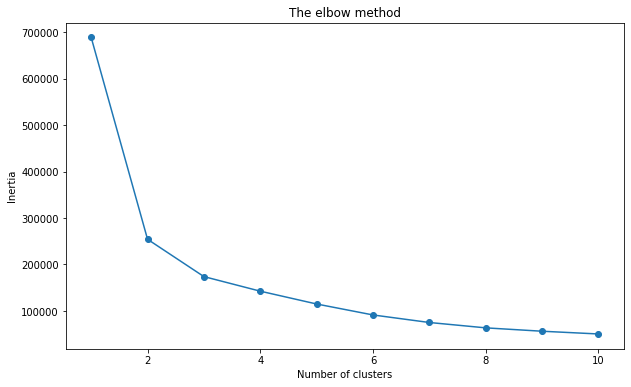

In [17]:
# execute functions
dat = rename_cols(dat)
dat = remove_outliers(dat)
dat = drop_cols(dat)
dat = variance_selector(dat, 0.01)
dat = drop_corr_features(dat, ["geopotential"]) # this drops only the highly correlated features that are still left
dat = sort_dat(dat)
dat = one_day_lag(dat) # do this before calculating rolling averages
dat = rolling_avg(dat, 10)
dat = rolling_std(dat, 10)
dat = rolling_max(dat, 10)
dat = rolling_min(dat, 10)
plot = plot_inertia(dat)

In [18]:
dat = geo_cluster(dat, 4)
dat = date_format(dat)

In [20]:
# display
dat.head()

,latitude,longitude,EVENT_TYPE,INJURIES_DIRECT,INJURIES_INDIRECT,DEATHS_DIRECT,DEATHS_INDIRECT,DAMAGE_PROPERTY,DAMAGE_CROPS,fraction_cloud_cover,...,fraction_cloud_cover_10_day_min,relative_humidity_10_day_min,temperature_10_day_min,u_component_wind_10_day_min,v_component_wind_10_day_min,vertical_velocity_10_day_min,geo_cluster,year,month,day
0,24.74,-124.779999,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,2015,1,4
1,24.74,-124.779999,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,7.532600,265.40286,-1.206722,-13.830118,0.329384,0,2015,1,5
2,24.74,-124.779999,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,7.532600,264.13422,-1.702287,-13.830118,0.310506,0,2015,1,6
3,24.74,-124.779999,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,7.018421,263.48780,-3.931420,-13.830118,-0.045236,0,2015,1,7
4,24.74,-124.779999,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,7.018421,261.52145,-3.931420,-13.830118,-0.089284,0,2015,1,8


In [21]:
# prove 1 day leg works
dat[(dat["year"] == 2015) & (dat["month"] == 1) & (dat["day"] == 2)]

,latitude,longitude,EVENT_TYPE,INJURIES_DIRECT,INJURIES_INDIRECT,DEATHS_DIRECT,DEATHS_INDIRECT,DAMAGE_PROPERTY,DAMAGE_CROPS,fraction_cloud_cover,...,fraction_cloud_cover_10_day_min,relative_humidity_10_day_min,temperature_10_day_min,u_component_wind_10_day_min,v_component_wind_10_day_min,vertical_velocity_10_day_min,geo_cluster,year,month,day
1409,24.74,-123.939999,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,2015,1,2
3234,24.74,-123.099999,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,2015,1,2
5059,24.74,-122.259999,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,2015,1,2
6884,24.74,-121.419999,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,2015,1,2
8709,24.74,-120.579999,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,2015,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3767969,49.10,-71.019999,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1,2015,1,2
3769794,49.10,-70.179999,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1,2015,1,2
3771619,49.10,-69.339999,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1,2015,1,2
3773444,49.10,-68.499999,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1,2015,1,2


In [22]:
# save csv
#dat.to_csv("datasets/dat_fe.csv")